# Gaussian Mixture Modelによるクラスタリング

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

In [2]:
def pca(X, target):
    pca = PCA(n_components=2, whiten=False)
    X_trans = pca.fit_transform(X)
    
    plt.scatter(X_trans[:, 0], X_trans[:, 1], c=target, cmap=plt.cm.rainbow)
    plt.show()
    
def show_clusters(clusters):
    data = np.array(sum(clusters, []))
    labels = np.array(sum([[str(i)]*len(cluster) for i, cluster in enumerate(clusters)], []))
    pca(data, labels)

In [3]:
def gaussian(X, mu, sigma):
    dim = X.shape[1]
    sigma_inv = np.linalg.inv(sigma.T).T
    diff = X[:, :, None] - mu
    exponent = np.sum(np.einsum('nik,ijk->njk', diff, sigma_inv)*diff, axis=1)
    k = 1/(((2*np.pi)**dim)*np.sqrt(np.linalg.det(sigma.T).T))
    return k * np.exp(-0.5*exponent)
    
class GaussianMixtureModel():
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X, max_iter=10):
        dim = X.shape[1]
        
        # pi, mu, sigmaの初期化
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = np.random.uniform(X.min(), X.max(), size=(dim, self.n_components))
        self.covs = np.repeat(np.eye(dim), self.n_components).reshape(dim, dim, self.n_components)
        
        # EMアルゴリズム
        for i in range(max_iter):
            old = np.concatenate([self.weights.ravel(), self.means.ravel(), self.covs.ravel()])
            res = self.expectation(X)
            self.maximization(X, res)
            new = np.concatenate([self.weights.ravel(), self.means.ravel(), self.covs.ravel()])
            if np.allclose(old, new):
                print('converged in {} iter'.format(i))
                return
        
        print('not converged')
        
    def expectation(self, X):
        gammas = self.weights * gaussian(X, self.means, self.covs)
        gammas /= gammas.sum(axis=-1, keepdims=True)
        return gammas
    
    def maximization(self, X, gammas):
        Nk = np.sum(gammas, axis=0)
        self.means = X.T.dot(gammas) / Nk
        diff = X[:, :, None] - self.means
        self.covs = np.einsum('nik,njk->ijk', diff, diff*np.expand_dims(gammas, 1))/Nk
        self.weights = Nk / len(X)
    
    def predict_proba(self, X):
        res = self.weights * gaussian(X, self.means, self.covs)
        return np.sum(res, axis=-1)
    
    def predict(self, X):
        res = self.weights * gaussian(X, self.means, self.covs)
        return np.argmax(res, axis=-1)

In [4]:
X, target = load_iris(return_X_y=True)

converged in 43 iter


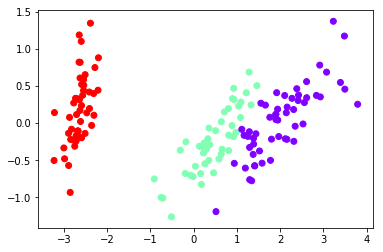

In [5]:
np.random.seed(150)  # seedによって結果が変わる
model = GaussianMixtureModel(n_components=3)
model.fit(X, max_iter=100)
clusters = model.predict(X)
pca(X, clusters)